We study the computional time of proposed approach in the paper with a new solver using Nyström approximation.

Student: 

CELANIE Erwan

NEL Louis

## Installing code libray

In [1]:
"""
This code is by the authors of the paper and can be found at https://github.com/taralloc/dc-kpca.
"""
!git clone https://github.com/taralloc/dc-kpca.git
%cd dc-kpca
!pip install -r requirements.txt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import time
import scipy.linalg
import scipy.sparse.linalg
from sklearn.utils.extmath import _randomized_eigsh
from kernels import kernel_factory
from scipy.optimize import minimize
import numpy as np
TensorType = torch.DoubleTensor
torch.set_default_tensor_type(TensorType)

Cloning into 'dc-kpca'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 11 (delta 0), reused 8 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (11/11), 6.42 KiB | 2.14 MiB/s, done.
/content/dc-kpca


/usr/local/lib/python3.10/dist-packages/torch/__init__.py:1145: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


## DC-KPCA with LFBGS

In [2]:
#Definition of the dual loss
def dual(G, H):
    GH = G @ H
    HTGH = H.t() @ GH
    eigvals = torch.real(torch.linalg.eigvals(HTGH))
    R = torch.sum(torch.sqrt(eigvals))
    loss = 1 / 2.0 * torch.trace(H.t() @ H) - R
    return -float(loss)

#LFBGS method for DC-KPCA
def dual_scipy(G, s, maxiter=10):
    N = G.shape[0]
    torch.manual_seed(5)
    H = torch.randn((N,s)).double()

    eta = 1

    GH, HTGH = None, None

    def f(H):
        global HTGH
        global GH
        H = torch.from_numpy(H).view(N,s)
        GH = G @ H
        HTGH = H.t() @ GH
        eigvals = torch.real(torch.linalg.eigvals(HTGH))
        R = torch.sum(torch.sqrt(eigvals))
        loss = eta/2.0 * torch.trace(H.t() @ H) - R
        return loss.double().numpy()


    def grad(H):
        global HTGH
        global GH
        H = torch.from_numpy(H).view(N,s)
        U, D, V = torch.svd(HTGH, some=False)
        D = torch.diag(1./(2*torch.sqrt(D)))
        grad = eta * H - 2*GH@U@D@U.t()
        return grad.flatten().double().numpy()

    res = minimize(f, H.numpy().flatten(), method='L-BFGS-B', jac=grad,
                   options={'gtol': 0, 'disp': False, 'ftol': 0, 'maxiter': maxiter})
    H = torch.from_numpy(res.x).view(N,s)

    return H

## Nyström approximation code

In [3]:
def get_k_largest_eig(W):
    lmb,vec = np.linalg.eigh(W)
    #lmb = lmb.real
    #vec = vec.real
    sorted_indices = np.argsort(lmb)[::-1]
    lmb = lmb[sorted_indices]
    vec = vec[:, sorted_indices]
    return lmb, vec

def nystrom_approx(K, s,D = 100):
    n = K.shape[0]
    J = np.random.randint(0,n,D)
    C = K[:,J]
    W = K[np.ix_(J,J)]
    lmb, vec = get_k_largest_eig(W)
    return C,lmb,vec

## Benchmark

In [4]:
#Define KPCA problem
torch.manual_seed(2)
N = 1024
d = 128
X = torch.randn((N, d))
X = X - X.mean(axis=0)
kernel = kernel_factory("laplace", {"sigma2": X.shape[1] * X.var() * 0.01})
G = kernel(X.t())
target_err = 1
s = 20
bench_times = 5

# FULL SVD
t0 = time.time()
U1, S1, V1t = scipy.linalg.svd(G.numpy())
time_svd = time.time() - t0
U1, S1, V1 = torch.from_numpy(U1), torch.from_numpy(S1), torch.from_numpy(V1t).t()
optimal_err = 0.5*float(torch.sum(S1[:s]))

# Nyström approximation
time_nystrom = 0
G_numpy = G.numpy()
n = G_numpy.shape[0]
for _ in range(bench_times):
    t0 = time.time()
    C,lmb,vec = nystrom_approx(G_numpy, s,D = 10)
    time_nystrom += time.time() - t0
time_nystrom /= bench_times
H_nystrom = torch.from_numpy(C @vec[:,:s] @ np.diag(1/np.sqrt(lmb[:s])))
nystrom_err_abs = float(dual(G,H_nystrom))
nystrom_err = abs(nystrom_err_abs-optimal_err) / optimal_err * 100

# LBFGS
time_lbfgs = 0
for _ in range(bench_times):
    t0 = time.time()
    H = dual_scipy(G, s)
    time_lbfgs += time.time() - t0
time_lbfgs /= bench_times
lbfgs_err_abs = float(dual(G, H))
lbfgs_err = abs(lbfgs_err_abs-optimal_err) / optimal_err * 100

# LANCZOS
time_eigsh = 0
for _ in range(bench_times):
    t0 = time.time()
    S2, V2 = scipy.sparse.linalg.eigsh(G.numpy(), k=s)
    time_eigsh += time.time() - t0
    S2, V2 = torch.from_numpy(S2), torch.from_numpy(V2)
time_eigsh /= bench_times
eigsh_err_abs = float(dual(G, V2@torch.diag(torch.sqrt(S2))))
eigsh_err = abs(eigsh_err_abs-optimal_err) / optimal_err * 100
# RANDOMIZED SVD
time_rsvd = 0
for _ in range(bench_times):
    t0 = time.time()
    S, U = _randomized_eigsh(G.numpy(), n_components=s, selection="module", random_state=1)
    time_rsvd += time.time() - t0
S, U = torch.from_numpy(S), torch.from_numpy(U)
time_rsvd /= bench_times
randsvd_err_abs = float(dual(G, U@torch.diag(torch.sqrt(S))))
randsvd_err = abs(randsvd_err_abs-optimal_err) / optimal_err * 100

## Comparison analysis

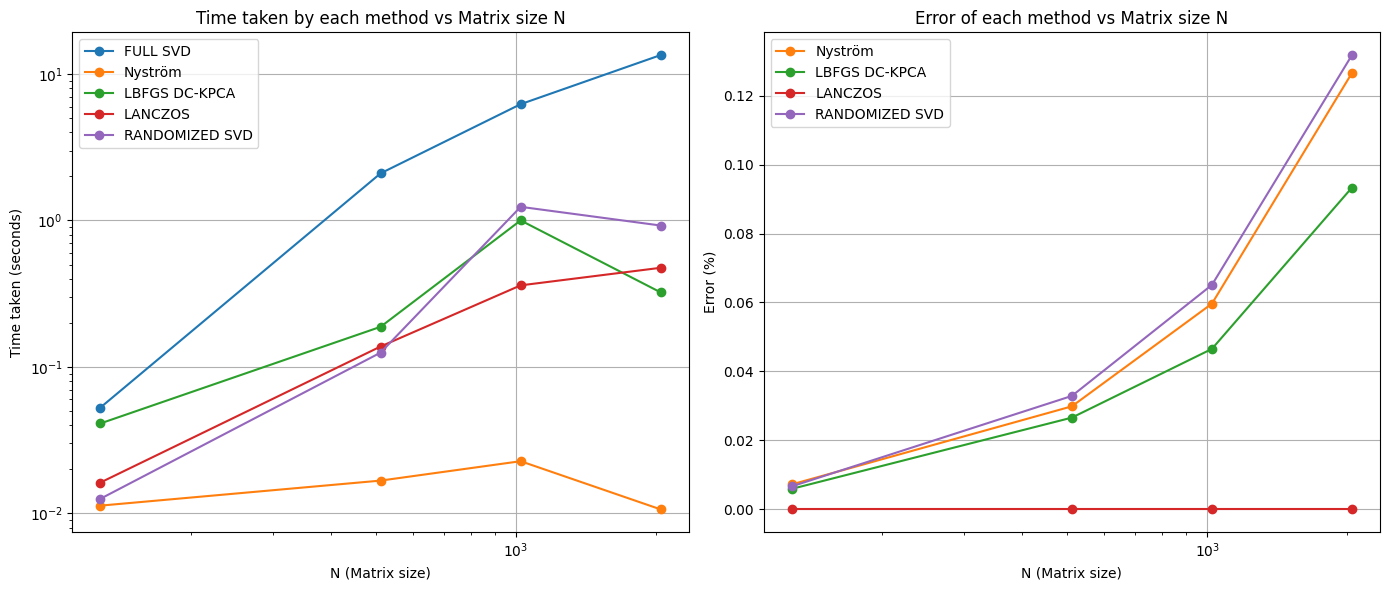

In [5]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.sparse.linalg



def run_benchmarks_with_error(N_values, d=128, s=20, bench_times=5):
    time_results = {
        "FULL SVD": [],
        "Nyström": [],
        "LBFGS DC-KPCA": [],
        "LANCZOS": [],
        "RANDOMIZED SVD": []
    }
    error_results = {
        "Nyström": [],
        "LBFGS DC-KPCA": [],
        "LANCZOS": [],
        "RANDOMIZED SVD": []
    }

    for N in N_values:
        # Setup
        torch.manual_seed(2)
        X = torch.randn((N, d))
        X = X - X.mean(axis=0)
        kernel = kernel_factory("laplace", {"sigma2": X.shape[1] * X.var() * 0.01})
        G = kernel(X.t())
        G_numpy = G.numpy()
        # FULL SVD
        t0 = time.time()
        U1, S1, V1t = scipy.linalg.svd(G.numpy())
        time_results["FULL SVD"].append(time.time() - t0)
        U1, S1, V1 = torch.from_numpy(U1), torch.from_numpy(S1), torch.from_numpy(V1t).t()
        optimal_err = 0.5 * float(torch.sum(S1[:s]))

        # Nyström approximation

        time_nystrom = 0

        for _ in range(bench_times):
            t0 = time.time()
            C, lmb, vec = nystrom_approx(G_numpy, s, D=100)
            time_nystrom += time.time() - t0
        time_results["Nyström"].append(time_nystrom / bench_times)

        H_nystrom = torch.from_numpy(C @ vec[:,:s] @ np.diag(1 / np.sqrt(lmb[:s])))
        nystrom_err_abs = float(dual(G, H_nystrom))
        nystrom_err = abs(nystrom_err_abs - optimal_err) / optimal_err * 100
        error_results["Nyström"].append(nystrom_err)

        # LBFGS
        time_lbfgs = 0
        for _ in range(bench_times):
            t0 = time.time()
            H = dual_scipy(G, s)
            time_lbfgs += time.time() - t0
        time_results["LBFGS DC-KPCA"].append(time_lbfgs / bench_times)

        lbfgs_err_abs = float(dual(G, H))
        lbfgs_err = abs(lbfgs_err_abs - optimal_err) / optimal_err * 100
        error_results["LBFGS DC-KPCA"].append(lbfgs_err)

        # LANCZOS
        time_eigsh = 0
        for _ in range(bench_times):
            t0 = time.time()
            S2, V2 = scipy.sparse.linalg.eigsh(G.numpy(), k=s)
            time_eigsh += time.time() - t0
        time_results["LANCZOS"].append(time_eigsh / bench_times)

        S2, V2 = torch.from_numpy(S2), torch.from_numpy(V2)
        eigsh_err_abs = float(dual(G, V2 @ torch.diag(torch.sqrt(S2))))
        eigsh_err = abs(eigsh_err_abs - optimal_err) / optimal_err * 100
        error_results["LANCZOS"].append(eigsh_err)

        # RANDOMIZED SVD
        time_rsvd = 0
        for _ in range(bench_times):
            t0 = time.time()
            S, U = _randomized_eigsh(G.numpy(), n_components=s, selection="module", random_state=1)
            time_rsvd += time.time() - t0
        time_results["RANDOMIZED SVD"].append(time_rsvd / bench_times)

        S, U = torch.from_numpy(S), torch.from_numpy(U)
        randsvd_err_abs = float(dual(G, U @ torch.diag(torch.sqrt(S))))
        randsvd_err = abs(randsvd_err_abs - optimal_err) / optimal_err * 100
        error_results["RANDOMIZED SVD"].append(randsvd_err)

    return time_results, error_results


# Define the N values and run the benchmarks
N_values = [128, 512, 1024,2048]
times, errors = run_benchmarks_with_error(N_values)


# Color Palette for methods
colors = {
    "FULL SVD": "tab:blue",
    "Nyström": "tab:orange",
    "LBFGS DC-KPCA": "tab:green",
    "LANCZOS": "tab:red",
    "RANDOMIZED SVD": "tab:purple"
}

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plotting Time Taken
for method, time_taken in times.items():
    ax1.plot(N_values, time_taken, label=method, marker='o', color=colors[method])
ax1.set_xlabel("N (Matrix size)")
ax1.set_ylabel("Time taken (seconds)")
ax1.set_title("Time taken by each method vs Matrix size N")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.legend()
ax1.grid(True)

# Plotting Errors
for method, error in errors.items():
    ax2.plot(N_values, error, label=method, marker='o', color=colors[method])
ax2.set_xlabel("N (Matrix size)")
ax2.set_ylabel("Error (%)")
ax2.set_title("Error of each method vs Matrix size N")
ax2.set_xscale("log")
ax2.legend()
ax2.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

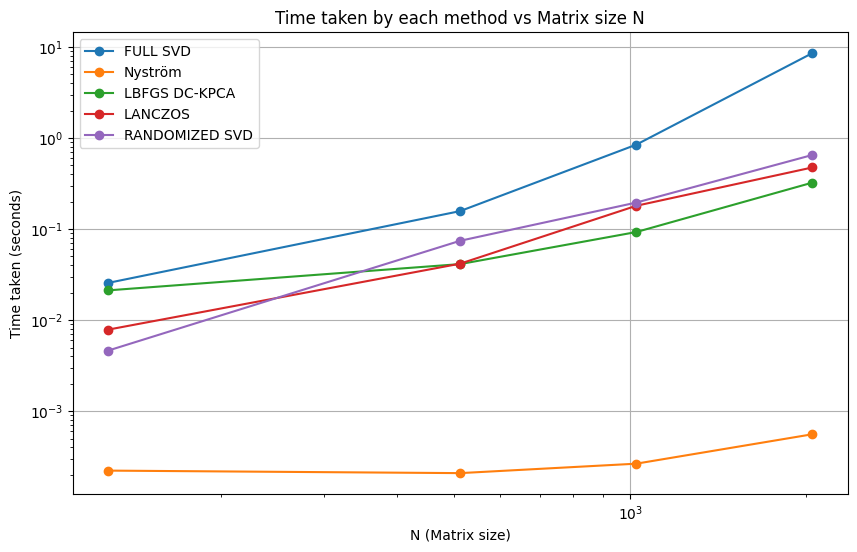

In [6]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.sparse.linalg


def run_benchmarks(N_values, d=128, s=20, bench_times=5):
    time_results = {
        "FULL SVD": [],
        "Nyström": [],
        "LBFGS DC-KPCA": [],
        "LANCZOS": [],
        "RANDOMIZED SVD": []
    }

    for N in N_values:
        # Setup
        torch.manual_seed(2)
        X = torch.randn((N, d))
        X = X - X.mean(axis=0)
        kernel = kernel_factory("laplace", {"sigma2": X.shape[1] * X.var() * 0.01})
        G = kernel(X.t())

        # FULL SVD
        t0 = time.time()
        U1, S1, V1t = scipy.linalg.svd(G.numpy())
        time_results["FULL SVD"].append(time.time() - t0)

        # Nyström approximation
        time_nystrom = 0
        G_numpy = G.numpy()
        for _ in range(bench_times):
            t0 = time.time()
            C, lmb, vec = nystrom_approx(G_numpy, s, D=10)
            time_nystrom += time.time() - t0
        time_results["Nyström"].append(time_nystrom / bench_times)

        # LBFGS
        time_lbfgs = 0
        for _ in range(bench_times):
            t0 = time.time()
            H = dual_scipy(G, s)
            time_lbfgs += time.time() - t0
        time_results["LBFGS DC-KPCA"].append(time_lbfgs / bench_times)

        # LANCZOS
        time_eigsh = 0
        for _ in range(bench_times):
            t0 = time.time()
            S2, V2 = scipy.sparse.linalg.eigsh(G.numpy(), k=s)
            time_eigsh += time.time() - t0
        time_results["LANCZOS"].append(time_eigsh / bench_times)

        # RANDOMIZED SVD
        time_rsvd = 0
        for _ in range(bench_times):
            t0 = time.time()
            S, U = _randomized_eigsh(G.numpy(), n_components=s, selection="module", random_state=1)
            time_rsvd += time.time() - t0
        time_results["RANDOMIZED SVD"].append(time_rsvd / bench_times)

    return time_results

# Define the N values and run the benchmarks
N_values = [128, 512, 1024,2048]
times = run_benchmarks(N_values)

# Plotting
plt.figure(figsize=(10, 6))
for method, time_taken in times.items():
    plt.plot(N_values, time_taken, label=method, marker='o')

plt.xlabel("N (Matrix size)")
plt.ylabel("Time taken (seconds)")
plt.title("Time taken by each method vs Matrix size N")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()
